# Desafío 4

## LSTM Bot QA

### Datos

Voy a usar los datos del challenge ConvAI2 (Conversational Intelligence Challenge 2), que contienen conversaciones en inglés. Con estos datos voy a construir un BOT capaz de responder preguntas de los usuarios (QA).  
[LINK](http://convai.io/data/)

In [7]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [8]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [9]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [10]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [11]:
print(data[1])

{'dialog': [{'id': 0, 'sender': 'participant1', 'text': 'Hello!', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 1, 'sender': 'participant2', 'text': 'Hi! How are you?', 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 2, 'sender': 'participant1', 'text': 'Not bad! And You?', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 3, 'sender': 'participant2', 'text': "I'm doing well. Just got engaged to my high school sweetheart.", 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 4, 'sender': 'participant1', 'text': 'Wowowowow! Congratulations! Is she pretty?', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 5, 'sender': 'participant2', 'text': "She 's pretty cute. She invited me to dinner tonight. 🙂", 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 6, 'sender': 'participant1', 'text': 'Cool! Have a good time you both! And what is your hobby?', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 7, 'sender': 'participant2', 'tex

In [ ]:
import re
        
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [13]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### Preporcesamiento

- Limpio y normalizo los textos de preguntas y respuestas.
- Tokenizo las preguntas (`input_sentences`) y las respuestas (`output_sentences` + `output_sentences_inputs`) para obtener diccionarios palabra a índice.
- Calculo la longitud máxima de preguntas (`max_input_len`) y respuestas (`max_out_len`).
- Convierto cada oración a secuencias de enteros usando los diccionarios.
- Repito el proceso para todas las filas del dataset.
- Aplico padding a todas las secuencias para que tengan la misma longitud.
- Resultado: listas listas para alimentar el encoder (`encoder_input_sequences`) y el decoder (`decoder_output_sequences` y `decoder_targets`).


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenización inputs
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_sentences)
word2idx_inputs = tokenizer_inputs.word_index
max_input_len = max([len(s.split()) for s in input_sentences])

# Tokenización outputs
tokenizer_outputs = Tokenizer(filters='')  
tokenizer_outputs.fit_on_texts(output_sentences + output_sentences_inputs) 
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1
max_out_len = max([len(s.split()) for s in output_sentences])

# Convertir texto a secuencias
encoder_input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)
decoder_output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)
decoder_targets = tokenizer_outputs.texts_to_sequences(output_sentences)

# Padding
encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_input_len, padding='post')
decoder_output_sequences = pad_sequences(decoder_output_sequences, maxlen=max_out_len, padding='post')
decoder_targets = pad_sequences(decoder_targets, maxlen=max_out_len, padding='post')

print("Cantidad de secuencias:", len(encoder_input_sequences))
print("Encoder_input:", encoder_input_sequences[1])
print("Decoder_output:", decoder_output_sequences[1])
print("Decoder_target:", decoder_targets[1])


Cantidad de secuencias: 6033
Encoder_input: [11 10  7  2  0  0  0  0  0]
Decoder_output: [  2  29 192  32   3   0   0   0   0   0]
Decoder_target: [ 29 192  32   3   1   0   0   0   0   0]


### Embeddings

- Descargo GloVe y extraigo el archivo de vectores.
- Leo el archivo y creo un diccionario palabra a vector.
- Para cada palabra de mi vocabulario de inputs, busco su vector en GloVe.
- Si la palabra no existe, inicializo un vector aleatorio.
- Genero la matriz de embeddings lista para usar en la capa Embedding del LSTM.

In [15]:
import zipfile

glove_zip = 'glove.6B.zip'
if not os.path.isfile('glove.6B.300d.txt'):
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    gdown.download(url, glove_zip, quiet=False)

    # Descomprimir
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall('.')
else:
    print("GloVe 6B 300d ya está descargado")

GloVe 6B 300d ya está descargado


In [16]:
import numpy as np

embedding_dim = 300
glove_file = 'glove.6B.300d.txt'

embeddings_index = {}
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

num_words_input = len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words_input, embedding_dim))

for word, i in word2idx_inputs.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(embedding_matrix.shape)


(1800, 300)


### Entrenamiento del modelo

- Construyo un modelo **encoder-decoder** con LSTM utilizando los datos procesados previamente.  
- El encoder transforma la secuencia de entrada en un estado interno de tamaño 768.  
- El decoder recibe ese estado y genera la secuencia de salida palabra por palabra.  
- Uso embeddings preentrenados de GloVe en el encoder y embeddings entrenables en el decoder.  
- Compilo el modelo con optimizador Adam y pérdida `sparse_categorical_crossentropy`.  
- Entreno el modelo con un **10% de validación** y `EarlyStopping` para detener el entrenamiento si la validación no mejora.  
- Esto permite que el modelo aprenda a mapear secuencias de preguntas a secuencias de respuestas en el dataset.

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

latent_dim = 768  # tamaño del estado interno del LSTM

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(input_dim=len(word2idx_inputs)+1, output_dim=embedding_dim,
                    weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_out_len,))
dec_emb = Embedding(input_dim=len(word2idx_outputs)+1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(len(word2idx_outputs)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Preparar targets con la dimensión correcta
decoder_targets_exp = np.expand_dims(decoder_targets, -1)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

history = model.fit([encoder_input_sequences, decoder_output_sequences],
                    decoder_targets_exp,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.5270 - loss: 3.3092 - val_accuracy: 0.6697 - val_loss: 1.9904
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.6984 - loss: 1.7530 - val_accuracy: 0.7126 - val_loss: 1.7078
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.7335 - loss: 1.4650 - val_accuracy: 0.7212 - val_loss: 1.6057
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.7426 - loss: 1.3371 - val_accuracy: 0.7311 - val_loss: 1.5656
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.7508 - loss: 1.2592 - val_accuracy: 0.7366 - val_loss: 1.5368
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.7627 - loss: 1.1591 - val_accuracy: 0.7437 - val_loss: 1.5278
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.7682 - loss: 1.1133 - val_accuracy: 0.7462 - val_loss: 1.5072
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.7748 - loss: 1.0546 - val_accu

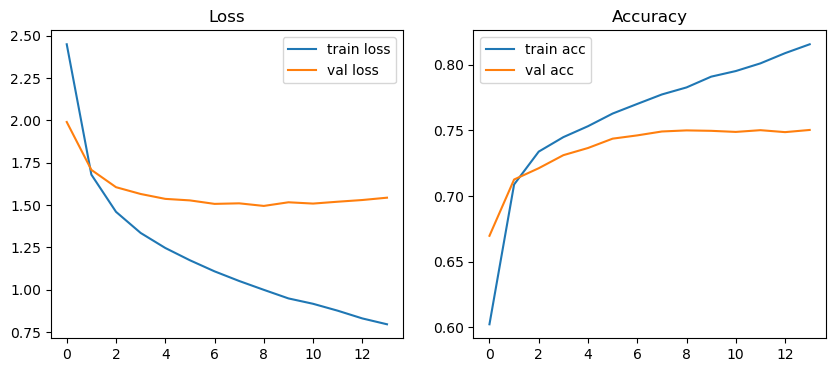

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Loss
axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[0].legend()

# Accuracy
axs[1].plot(history.history['accuracy'], label='train acc')
axs[1].plot(history.history['val_accuracy'], label='val acc')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.show()



### Inferencia

- Creo modelos separados de encoder y decoder para inferencia.
- El encoder transforma la secuencia de entrada en su estado interno.
- El decoder genera palabra por palabra usando el estado del encoder y su propio estado interno.
- Se inicializa con `<sos>` y se detiene al encontrar `<eos>` o al superar la longitud máxima.
- La función `decode_sequence` devuelve la respuesta generada por el modelo.

In [20]:
# Encoder para inferencia
encoder_model_inf = Model(encoder_inputs, encoder_states)

# Decoder para inferencia
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(input_dim=len(word2idx_outputs)+1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs2 = decoder_dense(decoder_lstm_outputs)
decoder_model_inf = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states)

idx2word_outputs = {i: w for w, i in word2idx_outputs.items()}

# Función para decodificar una secuencia
def decode_sequence(input_seq, temperature=0.1):
    states_value = encoder_model_inf.predict(input_seq)
    target_seq = np.array([[word2idx_outputs['<sos>']]])
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model_inf.predict([target_seq] + states_value)
        logits = output_tokens[0, -1, :]
        
        # muestreo con temperatura
        exp_logits = np.exp(logits / temperature)
        probs = exp_logits / np.sum(exp_logits)
        sampled_token_index = np.random.choice(len(probs), p=probs)
        
        sampled_word = idx2word_outputs[sampled_token_index]
        if sampled_word == '<eos>' or len(decoded_sentence.split()) > max_out_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return decoded_sentence.strip()

### Probar el modelo

- Tomo un ejemplo de texto de entrada.
- Convierto cada palabra a su índice según el vocabulario del encoder.
- Hago padding para que la secuencia tenga la longitud máxima esperada.
- Uso la función de decodificación para generar la respuesta palabra por palabra.
- Muestro la entrada original y la respuesta generada por el modelo.

In [23]:
# Tomo un ejemplo de texto de entrada
input_text = "hello how are you"

# Convierto cada palabra a su índice en el vocabulario de inputs
input_seq = [word2idx_inputs.get(w, 0) for w in input_text.split()]

# Hago padding para que tenga la longitud máxima esperada por el encoder
input_seq = pad_sequences([input_seq], maxlen=max_input_len)

print("Input:", input_text)

# Genero la respuesta usando la función de decodificación
decoded_sentence = decode_sequence(input_seq, temperature=0.1)
print("Temp = 0.1 - Output:", decoded_sentence)
decoded_sentence = decode_sequence(input_seq, temperature=0.5)
print("Temp = 0.5 - Output:", decoded_sentence)


# Muestro la entrada y la salida generada


Input: hello how are you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Temp = 0.1 - Output: works nothing make thanks don 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Temp = 0.5 - Output: kmc mars nevada lucille idiot wars favorite dave programmer hummus china


### Conclusiones

- Utilicé un LSTM con estado interno de 768 para generar las respuestas del modelo.  
- Probé la inferencia con dos temperaturas diferentes en la decodificación:  
  - Temp = 0.1 produce respuestas cortas, conservadoras, pero que no se entienden del todo.  
  - Temp = 0.5 genera respuestas más largas y variadas, aunque a veces son incoherentes o poco claras.  
- Esto muestra cómo la temperatura influye en la creatividad y la diversidad de las respuestas generadas por el modelo.  
- El modelo no predice del todo bien, por lo que posibles mejoras incluyen:
  - Aumentar la cantidad de datos de entrenamiento y agregar más pares de preguntas y respuestas.  
  - Usar embeddings más grandes.  
  - Explorar arquitecturas más profundas o modelos con atención (attention) en el decoder.  
  - Ajustar hiperparámetros como el tamaño del estado interno del LSTM y la longitud máxima de las secuencias.  
  - Aplicar técnicas de regularización y optimización para mejorar la generalización.